In [29]:
import os
import os.path
import sys
import importlib
import yaml
from copy import deepcopy
import subprocess

from time import time
from datetime import datetime

import numpy as np
import pandas as pd
import math

import scipy
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib import rcParams
import matplotlib as mpl
from matplotlib  import cm
from PIL import Image
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data

import multiprocessing

from sklearn.metrics import mean_squared_error

import copy
import importlib
#import calculateFES
#importlib.reload(calculateFES)
from numpy import ones,copy,cos,tan,pi,linspace

from scipy.interpolate import RegularGridInterpolator,LinearNDInterpolator, RectBivariateSpline,interpn, griddata
import warnings
warnings.filterwarnings("ignore")

In [30]:
frac = 1.5
width = [0.53*0.5*frac,0.65*0.5*frac,0.83*0.5*frac]
height = 0.78*0.5*frac

font = {'weight' : 'normal',
        'size'   : 22} 
plt.rc('font', **font)

from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#### Free energy surface 1 block, dimr,dimz=200

In [ ]:
# takes colvar files and calculates free energy surface for a given probe and analyte -  specification of r,z histogram values and cutoffs required

C0 = 1/(1661*1e-3)
kb = 8.31446261815324*0.001 #kJ/molK
temperature = 300
kbt = kb*temperature  #kJ/mol
preFactor = 2*kbt 
probe= ['bcd']
analyte = ['pfos','sds','TCAA']
#choose number of blocks
preFactor = 2*kbt #kJ/mol for entropy correction
blocks = 1 #3
cutoff1 = np.sqrt(3.5)
cutoff2 = 2
sfes_mast = []
smast = []
for dimr in [200]:
    for cutoff in [1]:
        dimz = dimr
        pmf_probe_analyte_zero_ref_boundary = {} # collect pmfs
        pmf_probe_analyte_zero_ref_global_minima = {} # collect pmfs

        #for ii in probe:
        for kk in analyte:
            for ii in probe:
                sfes = []
                sval = []
                pmf_probe_analyte_zero_ref_global_minima[ii+'_'+kk] = {}
                pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]  = {}

                #create holders
                fep = []
                avgFE,sdFE = [],[]
                avgkb,sdkb = [],[]
                #load data 
                colvarFile = '/project2/andrewferguson/maxtopel/PFAS_TACC/system-cd/reweights/'+kk+'-'+ii+"/COLVAR_reweight" #simDir + systemDir + colvarFileName
                #print(colvarFile)
                colvarData = pd.read_csv(colvarFile, comment="#", 
                                         delim_whitespace=True,names=["time", "angle", "r", 
                                                                      "baxis","mag", "pr", "pz", "bias"],
                                         skip_blank_lines=True)

                # discard initial few frames [frames where free energy is still being mapped]
                # subsample and randomize
                if kk=='pfos': #probe=='acd' or probe=='gcd' and analyte=='pfos':
                    s = 50000
                    d = -1 #500001
                    colvarD = colvarData[s:d].sample(frac = 1)
                else:
                    s = 100000
                    d = -1 #1000000
                    colvarD = colvarData[s:d:1].sample(frac = 1)        
                jmp = len(colvarD)//blocks

                print(ii,kk, len(colvarD), blocks, jmp)
                #\print(colvarD)
                for jj in range(blocks):
                    colvarData_init = colvarD[jmp*jj:jmp*(jj+1)] 
                    print(f'Before filter: {colvarData_init.shape}')

                    #colvarData = colvarData_init

                    print(f'After filter (<3. spherical cut): {colvarData.shape}')

                    ############################################################################################################
                    #make a 2D heat map
                    bias = colvarData_init['bias'] 
                    r = colvarData_init['r']
                    z = colvarData_init['baxis']
                    print(len(bias), ' is bias length')
                    # calculate weights of each frame in colvarData - CHECK THIS APPROACH (SUMMING THE BIASES)
                    weights = np.exp((bias) /kbt)        
                    xedges = np.linspace(0,cutoff2,dimr)
                    yedges = np.linspace(-cutoff2,cutoff2,dimz)
                    dr,dz = abs(xedges[0]-xedges[1]),abs(yedges[0]-yedges[1])
                    # get unbiased probabilities
                    fe, xedges,yedges = np.histogram2d(r,z,range=[[0,cutoff2],[-cutoff2,cutoff2]],
                                                       bins=(xedges,yedges),
                                                       weights=weights,density=True)


                    # get unbiased probabilities -- 1 D along r, z
                    fe_r, xedges_r = np.histogram(r, range=[0,cutoff1], bins=xedges, weights=weights,density=True)
                    fe_z, xedges_z = np.histogram(z, range=[-cutoff1,cutoff1], bins=yedges, weights=weights,density=True)
                    fe_r = fe_r.T
                    fe_z = fe_z.T
                    fe_r = -kbt*np.log(fe_r)
                    fe_z = -kbt*np.log(fe_z)
                    
                    fe = fe.T
                    feDf = -kbt*np.log(fe) # Compute free energy
######## correction
                    #correction
                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):
        #                     if xedges[ki]**2 + np.abs(yedges[kj])**2 > 1.25: # 2.0:
                   
                            if np.isnan(feDf[kj,ki]) or np.isinf(feDf[kj,ki]):
                                continue
    
                            s = np.sqrt(xedges[ki]**2+yedges[kj]**2)
                            feDf[kj,ki] += preFactor*np.log(s)
####################################


                    feDf_zero_ref_global_minima = feDf - feDf.min() # UNCOMMENT THIS FOR SETTING GLOBAL FREE ENERGY MINIMA AS ZERO

                    _block_data_global_minima = {'fe': feDf_zero_ref_global_minima, 
                                                 'xedges': xedges, 'yedges': yedges}

                    pmf_probe_analyte_zero_ref_global_minima[ii+'_'+kk]['block'+str(jj)] = _block_data_global_minima

                    # Find values of free energy on the boundary of the surface
                    avg_fe_beyond_cutoff=[]
                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):
        #                     if xedges[ki]**2 + np.abs(yedges[kj])**2 > 1.25: # 2.0:
                   
                            if np.isnan(feDf[kj,ki]) or np.isinf(feDf[kj,ki]):
                                continue
                            
                            #cutoffs
                            s = np.sqrt(xedges[ki]**2+yedges[kj]**2)
                            sfes.append(feDf[kj,ki])
                            sval.append(s)
                            if s > 1.2 and s < np.sqrt(3.5): #xedges[ki] > cutoff or yedges[kj] < -cutoff or yedges[kj] > cutoff and xedges[ki] < cutoff1 and yedges[kj] < cutoff1 and yedges[kj] > cutoff1:
                                avg_fe_beyond_cutoff.append(feDf[kj,ki])

                           

                    avg_fe_beyond_cutoff = np.array(avg_fe_beyond_cutoff)

                    print(f'avg:{avg_fe_beyond_cutoff.mean()}, sd:{np.std(avg_fe_beyond_cutoff)},max:{avg_fe_beyond_cutoff.max()}, min:{avg_fe_beyond_cutoff.min()}')

                    #feDf_zero_ref_boundary = feDf - feDf.max() #collect_fe_k_max # UNCOMMENT THIS FOR SETTING BOUNDARY FREE ENERGY TO ZERO
                    feDf_zero_ref_boundary = feDf - avg_fe_beyond_cutoff.mean() #collect_fe_k_max # UNCOMMENT THIS FOR SETTING BOUNDARY FREE ENERGY TO ZERO
                    fe_r = fe_r - avg_fe_beyond_cutoff.mean()
                    fe_z = fe_z - avg_fe_beyond_cutoff.mean()

                    print(xedges.min(), xedges.max(), yedges.min(), yedges.max())

                    _block_data_boundary = {'fe': feDf_zero_ref_boundary,
                                            'xedges': xedges,
                                            'yedges': yedges,
                                            'fe_r': fe_r,
                                             'xedges_r':xedges_r,
                                            'fe_z': fe_z,
                                             'xedges_z':xedges_z}
                                            #'fe_points_on_boundary': fe_points_on_boundary}

                    pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]['block'+str(jj)] = _block_data_boundary
                    sfes_mast.append(sfes)
                    smast.append(sval)
                    print(ii, kk, jj)
                    print(dimr,dimz,cutoff)


bcd pfos 1081281 1 1081281
Before filter: (1081281, 8)
After filter (<3. spherical cut): (1131282, 8)
1081281  is bias length
avg:43.63703636140387, sd:2.3145740889626896,max:53.877595497325494, min:36.13823581554402
0.0 2.0 -2.0 2.0
bcd pfos 0
200 200 1


bcd sds 516419 1 516419
Before filter: (516419, 8)
After filter (<3. spherical cut): (616420, 8)
516419  is bias length
avg:33.289719386603295, sd:3.136274861029846,max:44.934093664762905, min:25.80292408098715
0.0 2.0 -2.0 2.0
bcd sds 0
200 200 1
bcd TCAA 900000 1 900000
Before filter: (900000, 8)
After filter (<3. spherical cut): (1000001, 8)
900000  is bias length
avg:9.126966989995003, sd:1.5714205095670184,max:16.029877860995004, min:5.7593303379592236
0.0 2.0 -2.0 2.0
bcd TCAA 0
200 200 1


#### Convert to feDf as a function of s, histogram

In [ ]:

mt = []
iii = 0
for kk in analyte:
    mtot = []
    for ii in probe:
        bins = np.linspace(0, 2 + 1e-12, 51) # 10 bins, so 11 bin boundaries
        c = np.digitize(smast[iii], bins)
        c = list(c)
        indx = []
        lst =  list(enumerate(c))
        for ijk in range(len(bins)):
            indices = []
            for val in range(len(lst)):
                if lst[val][1]==ijk:
                    indices.append(lst[val][0])
            indx.append(indices)
        mval,stval = [],[]
        sfesp = np.array(sfes_mast[iii])
        for ijk in range(len(indx)):
            mval.append(np.mean(sfesp[indx[ijk]]))
        mtot.append(mval)
        iii+=1
    mt.append(mtot)

      

### plot FES as a function of s

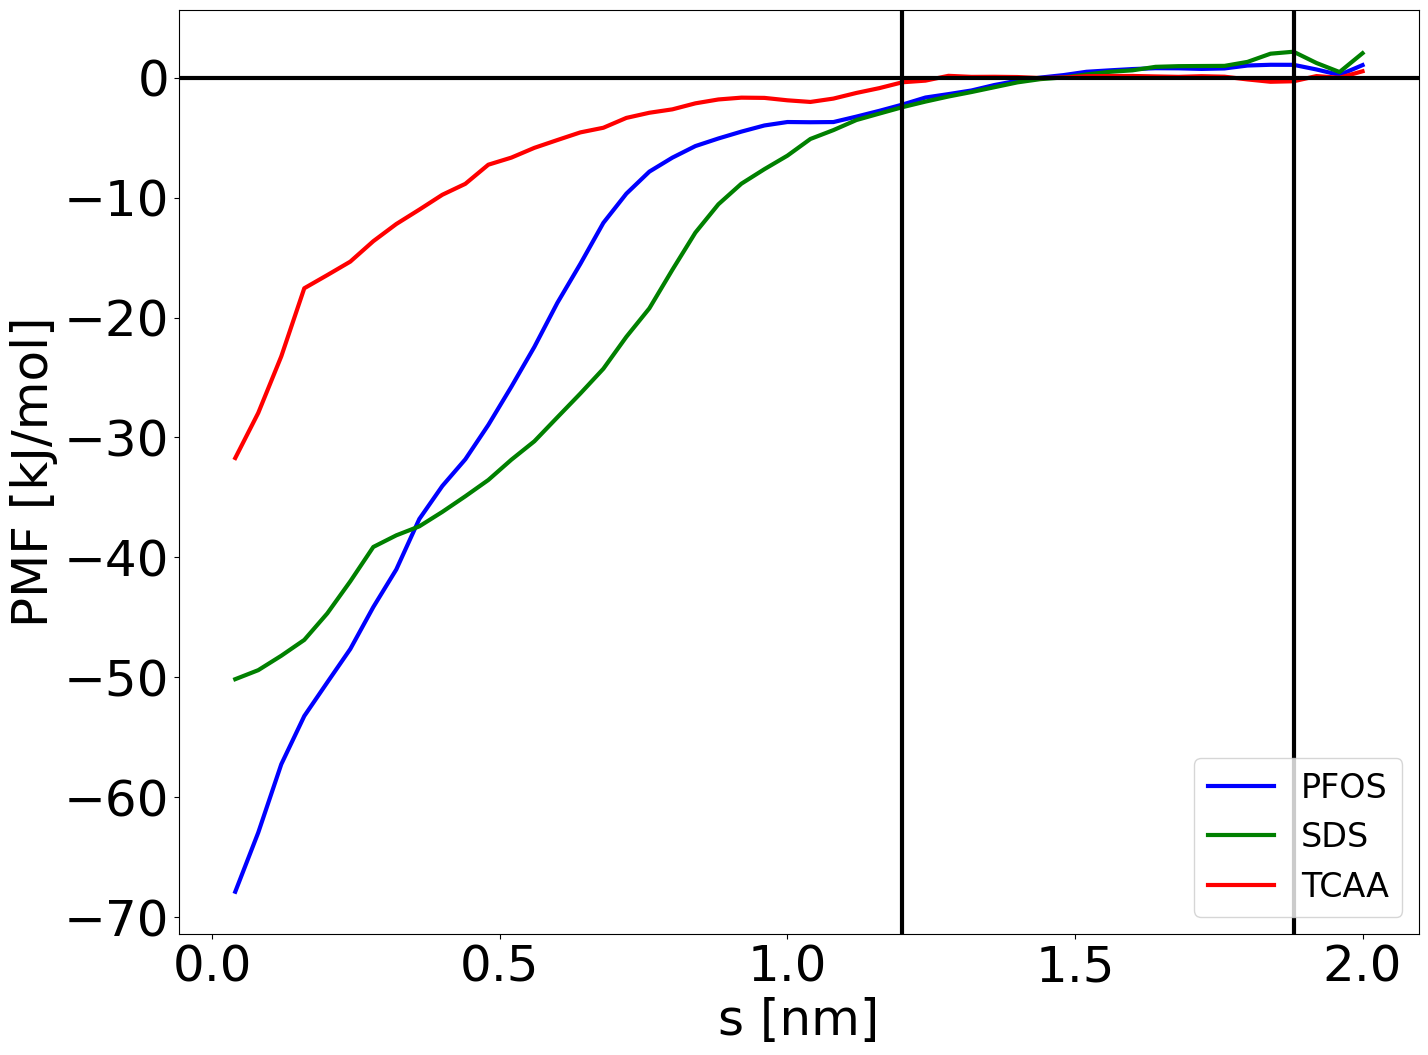

In [5]:
colors=['blue','green','red']
lbls = ['PFOS','SDS','TCAA']
iii = 0
plt.figure(figsize=(16, 12))
plt.xlabel('s [nm]',fontsize=36)
plt.ylabel('PMF [kJ/mol]',fontsize=36)
plt.xticks(fontsize=36)
plt.yticks(fontsize=36)
for kk in analyte:
    plts = mt[iii][0]
    plt.xticks(np.linspace(0,50,5),np.linspace(0,2,5))
    pltp = np.subtract(plts,np.mean(plts[30:47]))
    plt.plot(pltp, color=colors[iii], label=lbls[iii],linewidth=3)

    #plt.legend()
    iii +=1
plt.axvline(x=30,color='k',linewidth=3)
plt.axvline(x=47,color='k',linewidth=3)    
plt.axhline(y=0,color='k',linewidth=3)
plt.legend(loc='lower right',fontsize=24)
plt.savefig('/project2/andrewferguson/maxtopel/PFAS_TACC/system-cd/analysis/PFAS-II/s_fedf_BCD.pdf' ,dpi=300,transparent=True, format="pdf",bbox_inches='tight' )
#plt.show()
#plt.close()



pfos-bcd  done


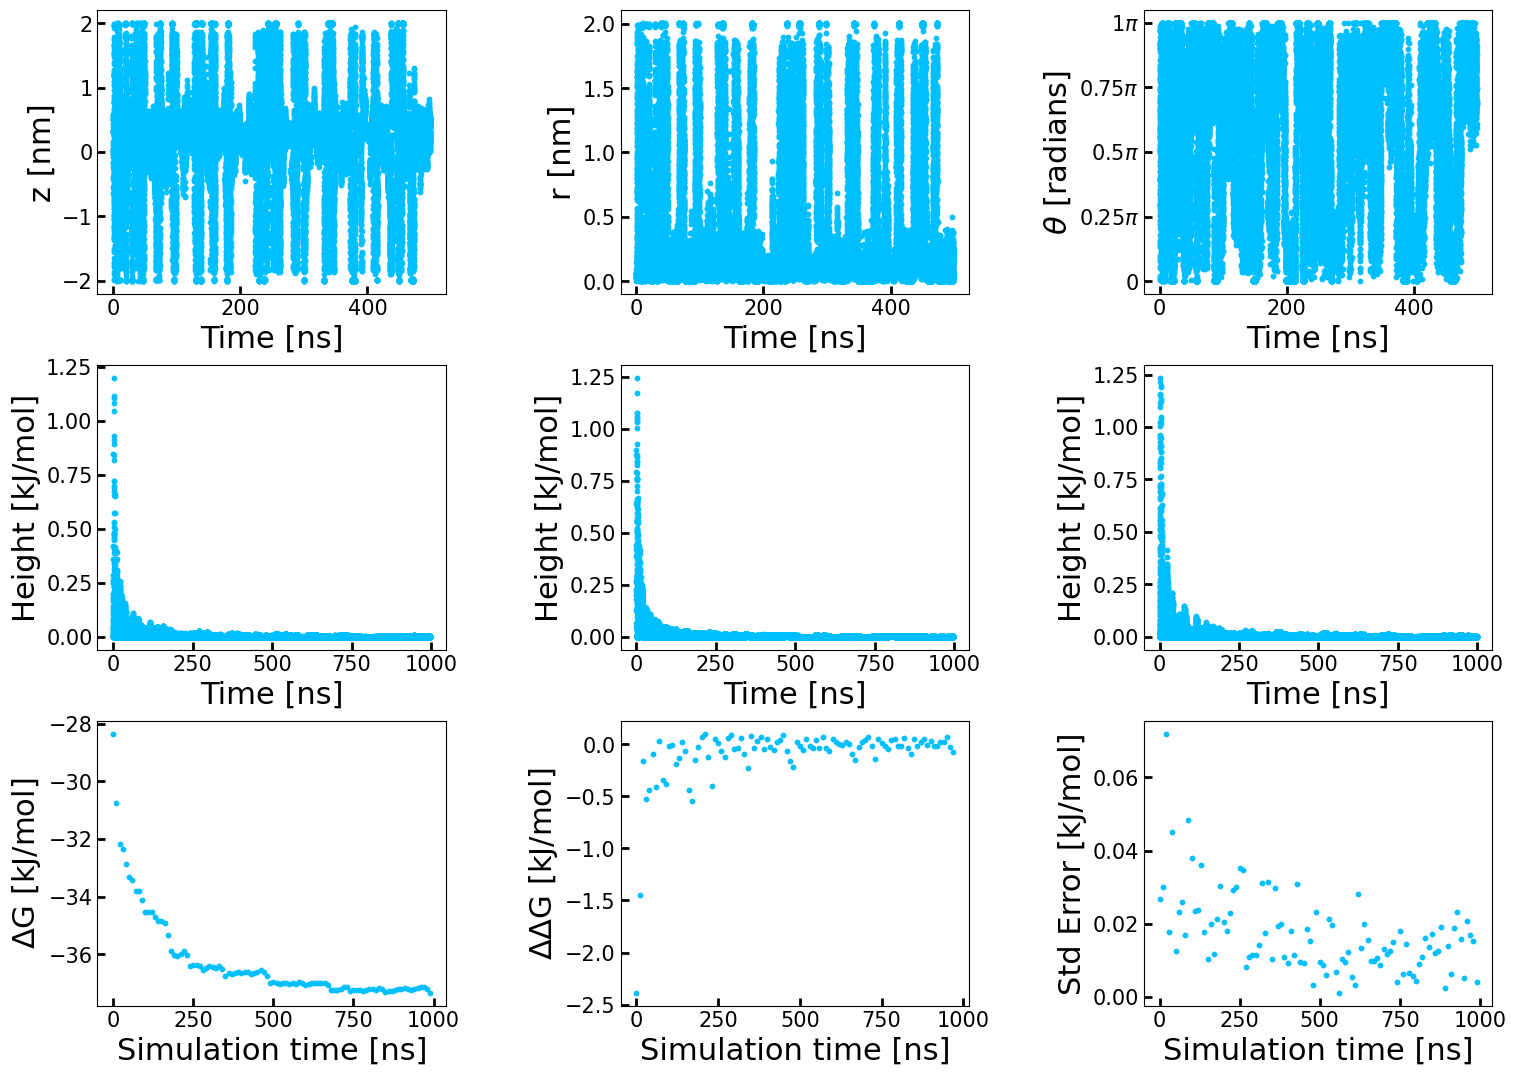

In [ ]:
# analysis of reweighted data to ensure convergence criteria
probe=['bcd']
analyte = ['pfos']
for ii in probe:
    for kk in analyte:
        scratchDir = '/project2/andrewferguson/maxtopel/PFAS_TACC/system-cd/'+str(kk)+'-f-'+str(ii)+"/sphere_2nm/reweight/"
        colvar = pd.read_csv(scratchDir + "COLVAR_reweight", 
                             comment="#", delim_whitespace=True,names=["time", "angle", "r", "baxis","mag", "pr", "pz", "bias"],skip_blank_lines=True)
     
        custombias = pd.read_csv(scratchDir + "BIAS", 
                             comment="#", delim_whitespace=True, names=["time", "r", "bz", "pr", "pz", "mag", "magbias"], skip_blank_lines=True)

        hills_angle = pd.read_csv(scratchDir + "../hills_angle.out",
                            comment="#", delim_whitespace=True,  names=["time", "angle", "sigma", "height", "bf"], skip_blank_lines=True)
        hills_r = pd.read_csv(scratchDir + "../hills_r",
                            comment="#", delim_whitespace=True,  names=["time", "r", "sigma", "height", "bf"],skip_blank_lines=True)
        hills_z = pd.read_csv(scratchDir + "../hills_r.out",
                            comment="#", delim_whitespace=True, names=["time", "z", "sigma", "height", "bf"], skip_blank_lines=True)
       

            
        time = np.multiply(np.arange(0,len(colvar.r)),0.1)
        time = time[0:499000:10]
        time_h = np.multiply(np.arange(0,999000),0.2)
        time_h = time_h[0:499000:10]
        colvar = colvar[0:499000:10]
        hills_angle = hills_angle[0:499000:10]
        hills_r = hills_r[0:499000:10]
        hills_z = hills_z[0:499000:10]
        
        #capture

        labelfont=10
        tickfont=15

        fig = plt.figure(figsize=[18,12])
        fig.tight_layout(pad=100.0)
        spec = GridSpec(ncols=3, nrows=3)
        fig.subplots_adjust(bottom=0.05, hspace=.25, wspace=.5)

        ax = ['ax1', 'ax2', 'ax3', 'ax4', 'ax5', 'ax6', 'ax7', 'ax8', 'ax9', 'ax10']

        kT = 300*0.008314
        preFactor = 2*kT

            
        col=0
        row=0
        rgaxis=['x', 'y', 'z']

        pc=0
        ax[pc] = fig.add_subplot(spec[row, col])
        ax[pc].tick_params(axis="x", labelsize=tickfont, direction='in', length=6, width=2, colors='black', rotation=0)
        ax[pc].tick_params(axis="y", labelsize=tickfont, direction='in', length=6, width=2, colors='black')
        ax[pc].tick_params(which='minor', direction='in', length=3, width=2)

        ax[pc].scatter(time/100, colvar.baxis, 
                       s=10, alpha=1, color='deepskyblue')
        ax[pc].set_xlabel('Time [ns]')
        ax[pc].set_ylabel('z [nm]')

        pc=1
        col=1
        ax[pc] = fig.add_subplot(spec[row, col])
        ax[pc].tick_params(axis="x", labelsize=tickfont, direction='in', length=6, width=2, colors='black', rotation=0)
        ax[pc].tick_params(axis="y", labelsize=tickfont, direction='in', length=6, width=2, colors='black')
        ax[pc].tick_params(which='minor', direction='in', length=3, width=2)

        ax[pc].scatter(time/100, colvar.r, 
                       s=10, alpha=1, color='deepskyblue')
        ax[pc].set_xlabel('Time [ns]')
        ax[pc].set_ylabel('r [nm]')


        pc=2
        row=0
        col=2
        ax[pc] = fig.add_subplot(spec[row, col])
        ax[pc].tick_params(axis="x", labelsize=tickfont, direction='in', length=6, width=2, colors='black', rotation=0)
        ax[pc].tick_params(axis="y", labelsize=tickfont, direction='in', length=6, width=2, colors='black')
        ax[pc].tick_params(which='minor', direction='in', length=3, width=2)

        ax[pc].scatter(time/100, colvar.angle, 
                       s=10, alpha=1, c='deepskyblue')
        pi = np.pi
        ax[pc].set_yticks([])


        from matplotlib.ticker import FuncFormatter, MultipleLocator
        #ax.xaxis.set_major_formatter(FormatStrFormatter('%g $\pi$'))
        ax[pc].yaxis.set_major_formatter(FuncFormatter(
           lambda val,pos: '{:g}$\pi$'.format(val/np.pi) if val !=0 else '0'
        ))
        ax[pc].yaxis.set_major_locator(MultipleLocator(base=np.pi/4))


        ax[pc].set_xlabel('Time [ns]')
        ax[pc].set_ylabel('$\\theta$ [radians]')

        
        pc=3
        row=1
        col=0
        ax[pc] = fig.add_subplot(spec[row, col])
        ax[pc].tick_params(axis="x", labelsize=tickfont, direction='in', length=6, width=2, colors='black', rotation=0)
        ax[pc].tick_params(axis="y", labelsize=tickfont, direction='in', length=6, width=2, colors='black')
        ax[pc].tick_params(which='minor', direction='in', length=3, width=2)

        ax[pc].scatter(time_h[0:len(hills_r.r)]/100, hills_r.height, 
                       s=10, alpha=1, color='deepskyblue')
        ax[pc].set_xlabel('Time [ns]')
        ax[pc].set_ylabel('Height [kJ/mol]')



        pc=4
        row=1
        col=1
        ax[pc] = fig.add_subplot(spec[row, col])
        ax[pc].tick_params(axis="x", labelsize=tickfont, direction='in', length=6, width=2, colors='black', rotation=0)
        ax[pc].tick_params(axis="y", labelsize=tickfont, direction='in', length=6, width=2, colors='black')
        ax[pc].tick_params(which='minor', direction='in', length=3, width=2)

        ax[pc].scatter(time_h[0:len(hills_angle.height)]/100, hills_angle.height, 
                       s=10, alpha=1, color='deepskyblue')
        ax[pc].set_xlabel('Time [ns]')
        ax[pc].set_ylabel('Height [kJ/mol]')


        pc=5
        row=1
        col=2
        ax[pc] = fig.add_subplot(spec[row, col])
        ax[pc].tick_params(axis="x", labelsize=tickfont, direction='in', length=6, width=2, colors='black', rotation=0)

        ax[pc].tick_params(axis="y", labelsize=tickfont, direction='in', length=6, width=2, colors='black')
        ax[pc].tick_params(which='minor', direction='in', length=3, width=2)

        ax[pc].scatter(time_h[0:len(hills_z.height)]/100, hills_z.height, 
                       s=10, alpha=1, color='deepskyblue')
        ax[pc].set_xlabel('Time [ns]')
        ax[pc].set_ylabel('Height [kJ/mol]')

        

        xlbl = range(0,1250,250)
        xax = np.linspace(0,100,5)      

        pc=6
        row=2
        col=0
        ax[pc] = fig.add_subplot(spec[row, col])
        ax[pc].tick_params(axis="x", labelsize=tickfont, direction='in', length=6, width=2, colors='black', rotation=0)

        ax[pc].tick_params(axis="y", labelsize=tickfont, direction='in', length=6, width=2, colors='black')
        ax[pc].tick_params(which='minor', direction='in', length=3, width=2)

        ax[pc].scatter(range(len(DG)), DG, 
                       s=10, alpha=1, color='deepskyblue')
        ax[pc].set_xlabel('Simulation time [ns]')
        ax[pc].set_ylabel('$\\Delta$G [kJ/mol]')
        ax[pc].set_xticks(xax,xlbl)

        pc=7
        row=2
        col=1
        ax[pc] = fig.add_subplot(spec[row, col])
        ax[pc].tick_params(axis="x", labelsize=tickfont, direction='in', length=6, width=2, colors='black', rotation=0)

        ax[pc].tick_params(axis="y", labelsize=tickfont, direction='in', length=6, width=2, colors='black')
        ax[pc].tick_params(which='minor', direction='in', length=3, width=2)

        ax[pc].scatter(range(len(ddG)), ddG, 
                       s=10, alpha=1, color='deepskyblue')
        ax[pc].set_xlabel('Simulation time [ns]')
        ax[pc].set_ylabel('$\\Delta\\Delta$G [kJ/mol]')
        ax[pc].set_xticks(xax,xlbl)

        pc=8
        row=2
        col=2
        ax[pc] = fig.add_subplot(spec[row, col])
        ax[pc].tick_params(axis="x", labelsize=tickfont, direction='in', length=6, width=2, colors='black', rotation=0)

        ax[pc].tick_params(axis="y", labelsize=tickfont, direction='in', length=6, width=2, colors='black')
        ax[pc].tick_params(which='minor', direction='in', length=3, width=2)

        ax[pc].scatter(range(len(ERR)), ERR, 
                       s=10, alpha=1, color='deepskyblue')
        ax[pc].set_xlabel('Simulation time [ns]')
        ax[pc].set_ylabel('Std Error [kJ/mol]')
        ax[pc].set_xticks(xax,xlbl)



        figName = 'Fig-'+str(kk)+'-'+str(ii)+'.png'
        print(str(kk)+'-'+str(ii), ' done')
        plt.savefig('/project2/andrewferguson/maxtopel/PFAS_TACC/system-cd/analysis/PFAS-II/S2.pdf' ,dpi=300,transparent=True, format="pdf",bbox_inches='tight' ) #(figName+'.pdf', bbox_inches = "tight", dpi=300,transparent=True)

[-36.619095141749625, -27.998721828709137, -7.236990259427596]
[0.04616560935513524, 0.07709529837089962, 0.031112409502547855]
['bcd_pfos', 'bcd_sds', 'bcd_TCAA']
[2376296.700669817, 75010.57251162129, 18.200408063827393]
[43920.110898143554, 2313.4714903991603, 0.2270964386486199]
[3.15661645e-02 7.65914798e-06]
['bcd_pfos', 'bcd_sds', 'bcd_TCAA']


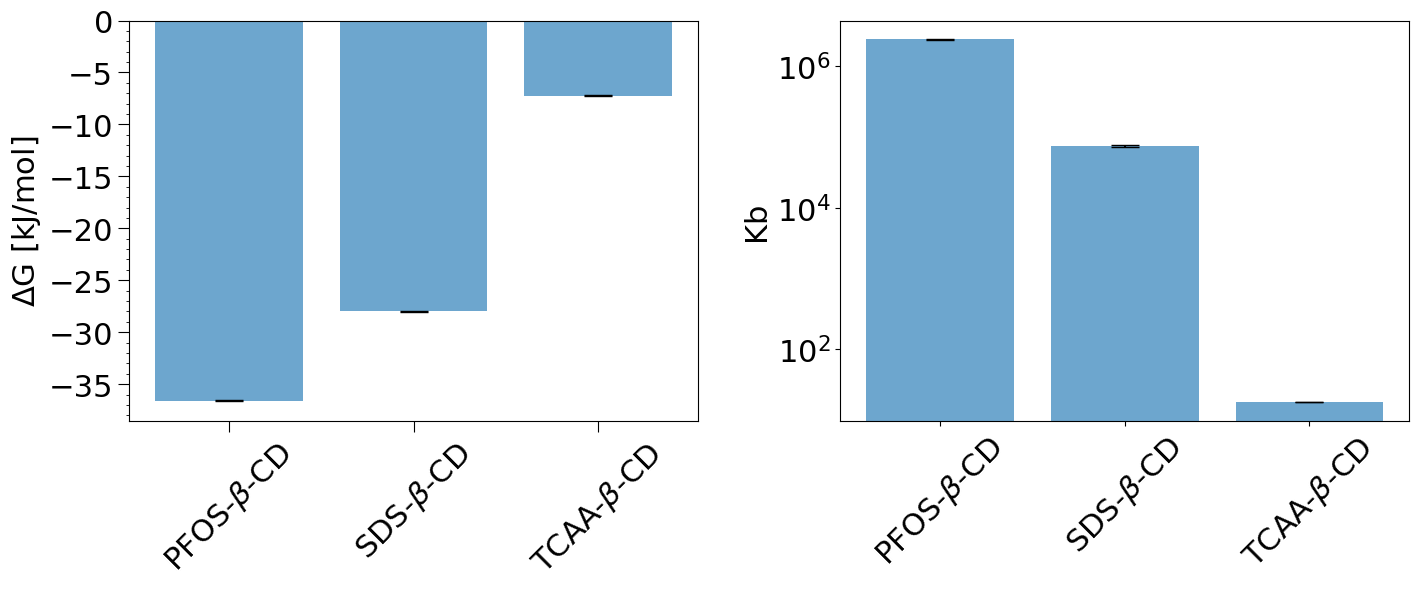

In [ ]:

#ploting relative free energy of binding for PFAS-CD systems FOR A GIVEN CHOICE OF dimr, dimz, cutoff
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from operator import add
# Set the figure size
fig = plt.figure(figsize=(16, 5))
lbl = ['PFOS-$\\beta$-CD','SDS-$\\beta$-CD','TCAA-$\\beta$-CD']

# Adjust spacing
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.25, hspace=0.25)

# Create a 3x3 grid
grid = GridSpec(1, 2)

probe= ['bcd']
analyte = ['pfos','sds','TCAA']

blocks = 3

deltag_kb_probe_analyte = {}
kji = 0
for k, kk in enumerate(analyte):
    for i, ii in enumerate(probe):
        
        selected_data = deltag_kb_probe_analyte_block
        
        deltag_blocks = []
        kb_blocks = []
        for bb in range(blocks):
            deltag = selected_data[ii+'_'+kk]['block'+str(bb)]['deltag']
            kb = selected_data[ii+'_'+kk]['block'+str(bb)]['kb']
            deltag_blocks.append(deltag)
            kb_blocks.append(kb)
            
            #print(deltag, kb)
            
        deltag_blocks = np.array(deltag_blocks)
        kb_blocks = np.array(kb_blocks)
        
        
        deltag_kb_probe_analyte[ii+'_'+kk] = {'avg_deltag': np.mean(deltag_blocks),
                                              'sd_deltag': np.std(deltag_blocks),
                                              'avg_kb': np.mean(kb_blocks),
                                              'sd_kb': np.std(kb_blocks)}

        
        
   

def convert_dict_of_dict(input_dict):
    result_dict = {}

    # Iterate through outer keys
    for outer_key, inner_dict in input_dict.items():
        # Iterate through inner keys
        for inner_key, value in inner_dict.items():
            # Check if the inner key is already in the result dictionary
            if inner_key not in result_dict:
                result_dict[inner_key] = {}

            # Add the value corresponding to the outer key
            result_dict[inner_key][outer_key] = value

    return result_dict

deltag_kb_probe_analyte = convert_dict_of_dict(deltag_kb_probe_analyte)



# # Create subplots
ax = plt.subplot(grid[0, 0])
# Extract keys and values from the dictionary
categories = list(deltag_kb_probe_analyte['avg_deltag'].keys())
values = list(deltag_kb_probe_analyte['avg_deltag'].values())
errors = list(deltag_kb_probe_analyte['sd_deltag'].values())
print(values)
print(errors)


# Plotting a bar chart
ax.bar(categories, values, yerr=errors, align='center', alpha=0.65, ecolor='black', capsize=10)
print(categories)
ax.set_xticks(categories, ['PFOS-$\\beta$-CD','SDS-$\\beta$-CD','TCAA-$\\beta$-CD'], rotation=45)
    
ax.set_ylabel(r'$\Delta$G [kJ/mol]')

#ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(5))
#ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=2)


# # Create subplots
ax = plt.subplot(grid[0, 1])
# Extract keys and values from the dictionary
categories = list(deltag_kb_probe_analyte['avg_kb'].keys())
values = list(deltag_kb_probe_analyte['avg_kb'].values())
errors = list(deltag_kb_probe_analyte['sd_kb'].values())
print(values)
print(errors)
values1 = values[0]#[0:3]
values2 = values[1:] #[3::]
errors1 = errors[0]#[0:3]
errors2 = errors[1:]#[3::]

print(np.divide(values2,values1))

# change to allign with number of components (a/b/g cd + PFAS/SDS/TCAA...)
#print(np.multiply(np.sqrt(list(map(add,np.square(np.divide(errors1,values1)),np.square(np.divide(errors2,values2))))),np.divide(values2,values1)))
# Plotting a bar chart
ax.bar(categories, values, yerr=errors, align='center', alpha=0.65, ecolor='black', capsize=10)
print(categories)
ax.set_xticks(categories, ['PFOS-$\\beta$-CD','SDS-$\\beta$-CD','TCAA-$\\beta$-CD'], rotation=45)
    
ax.set_ylabel(r'Kb')
ax.set_yscale('log')

plt.savefig('/project2/andrewferguson/maxtopel/PFAS_TACC/system-cd/analysis/PFAS-II/S4.pdf' ,dpi=300,transparent=True, format="pdf",bbox_inches='tight' )

        



#### plot as a function of r,z

TCAA acd
TCAA bcd
TCAA gcd
pfos acd
pfos bcd
pfos gcd
TCAA acd
TCAA bcd
TCAA gcd
pfos acd
pfos bcd
pfos gcd


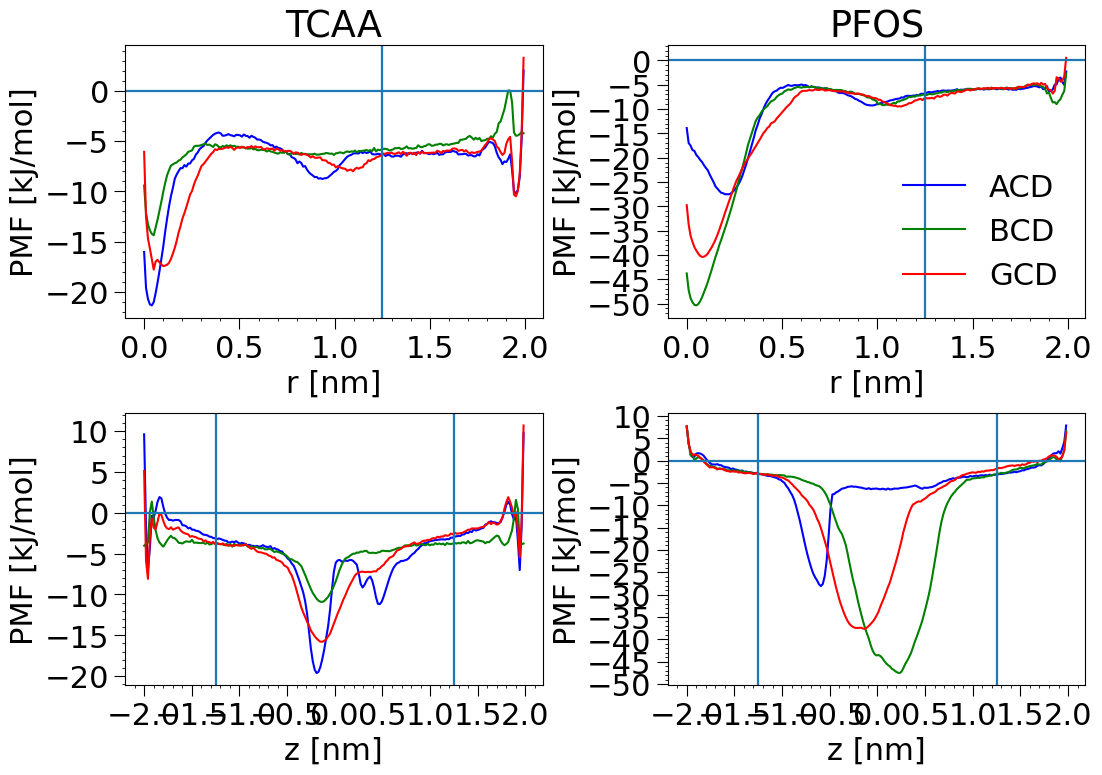

In [ ]:
#Spatial Resolution plots
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

# Set the figure size
fig = plt.figure(figsize=(12, 8))

# Adjust spacing
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.35)

# Create a 3x3 grid
grid = GridSpec(2, 2)

probe= ['acd','bcd','gcd']
analyte = ['TCAA','pfos']

selected_block = 0 # entire data is used.


colors=['blue','green','red']
for k, kk in enumerate(analyte):
    
    ax = plt.subplot(grid[0,k])
    ax.set_title(kk.upper())
    
    for i, ii in enumerate(probe):
        # Create subplots
        
        
        print(kk,ii)
        #selected_fe = pmf_probe_analyte_zero_ref_global_minima
        selected_fe = pmf_probe_analyte_zero_ref_boundary
        
        
        fe_r = selected_fe[ii+'_'+kk]['block'+str(selected_block)]['fe_r']
        xedges_r = selected_fe[ii+'_'+kk]['block'+str(selected_block)]['xedges_r']
        
        ax.plot(xedges_r[:-1], fe_r, color=colors[i], label=ii.upper())
        
        ax.set_xlabel('r [nm]')
        ax.set_ylabel('PMF [kJ/mol]')
        
        ax.xaxis.set_major_locator(MultipleLocator(0.5))
        ax.yaxis.set_major_locator(MultipleLocator(5))
        ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
        ax.yaxis.set_minor_locator(AutoMinorLocator(n=5))
        ax.tick_params(which='major', length=8)
        ax.tick_params(which='minor', length=2)
        
        ax.axvline(x=1.25)
        ax.axhline(y=0)
        
        
ax.legend(frameon=False)
        
colors=['blue','green','red']
for k, kk in enumerate(analyte):
    
    ax = plt.subplot(grid[1,k])
    
    for i, ii in enumerate(probe):
        # Create subplots
        
        
        print(kk,ii)
        #selected_fe = pmf_probe_analyte_zero_ref_global_minima
        selected_fe = pmf_probe_analyte_zero_ref_boundary
        
        
        fe_z = selected_fe[ii+'_'+kk]['block'+str(selected_block)]['fe_z']
        xedges_z = selected_fe[ii+'_'+kk]['block'+str(selected_block)]['xedges_z']
        
        ax.plot(xedges_z[:-1], fe_z, color=colors[i])
        
        ax.set_xlabel('z [nm]')
        ax.set_ylabel('PMF [kJ/mol]')
                  

#         ax.set_xlabel('r [nm]')
#         ax.set_ylabel('z [nm]')
#         ax.set_title(kk.upper()+':'+ii.upper())
        
        ax.xaxis.set_major_locator(MultipleLocator(0.5))
        ax.yaxis.set_major_locator(MultipleLocator(5))
        ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
        ax.yaxis.set_minor_locator(AutoMinorLocator(n=5))
        ax.tick_params(which='major', length=8)
        ax.tick_params(which='minor', length=2)
        
        ax.axvline(x=1.25)
        ax.axvline(x=-1.25)
        
        ax.axhline(y=0)
        
        
        

        

#### plot the surfaces using the saved dictionary, horizontal, vertical and render for cbar

0.0 2.0 -2.0 2.0
0.0 2.0 -2.0 2.0
0.0 2.0 -2.0 2.0
0.0 2.0 -2.0 2.0
0.0 2.0 -2.0 2.0
0.0 2.0 -2.0 2.0


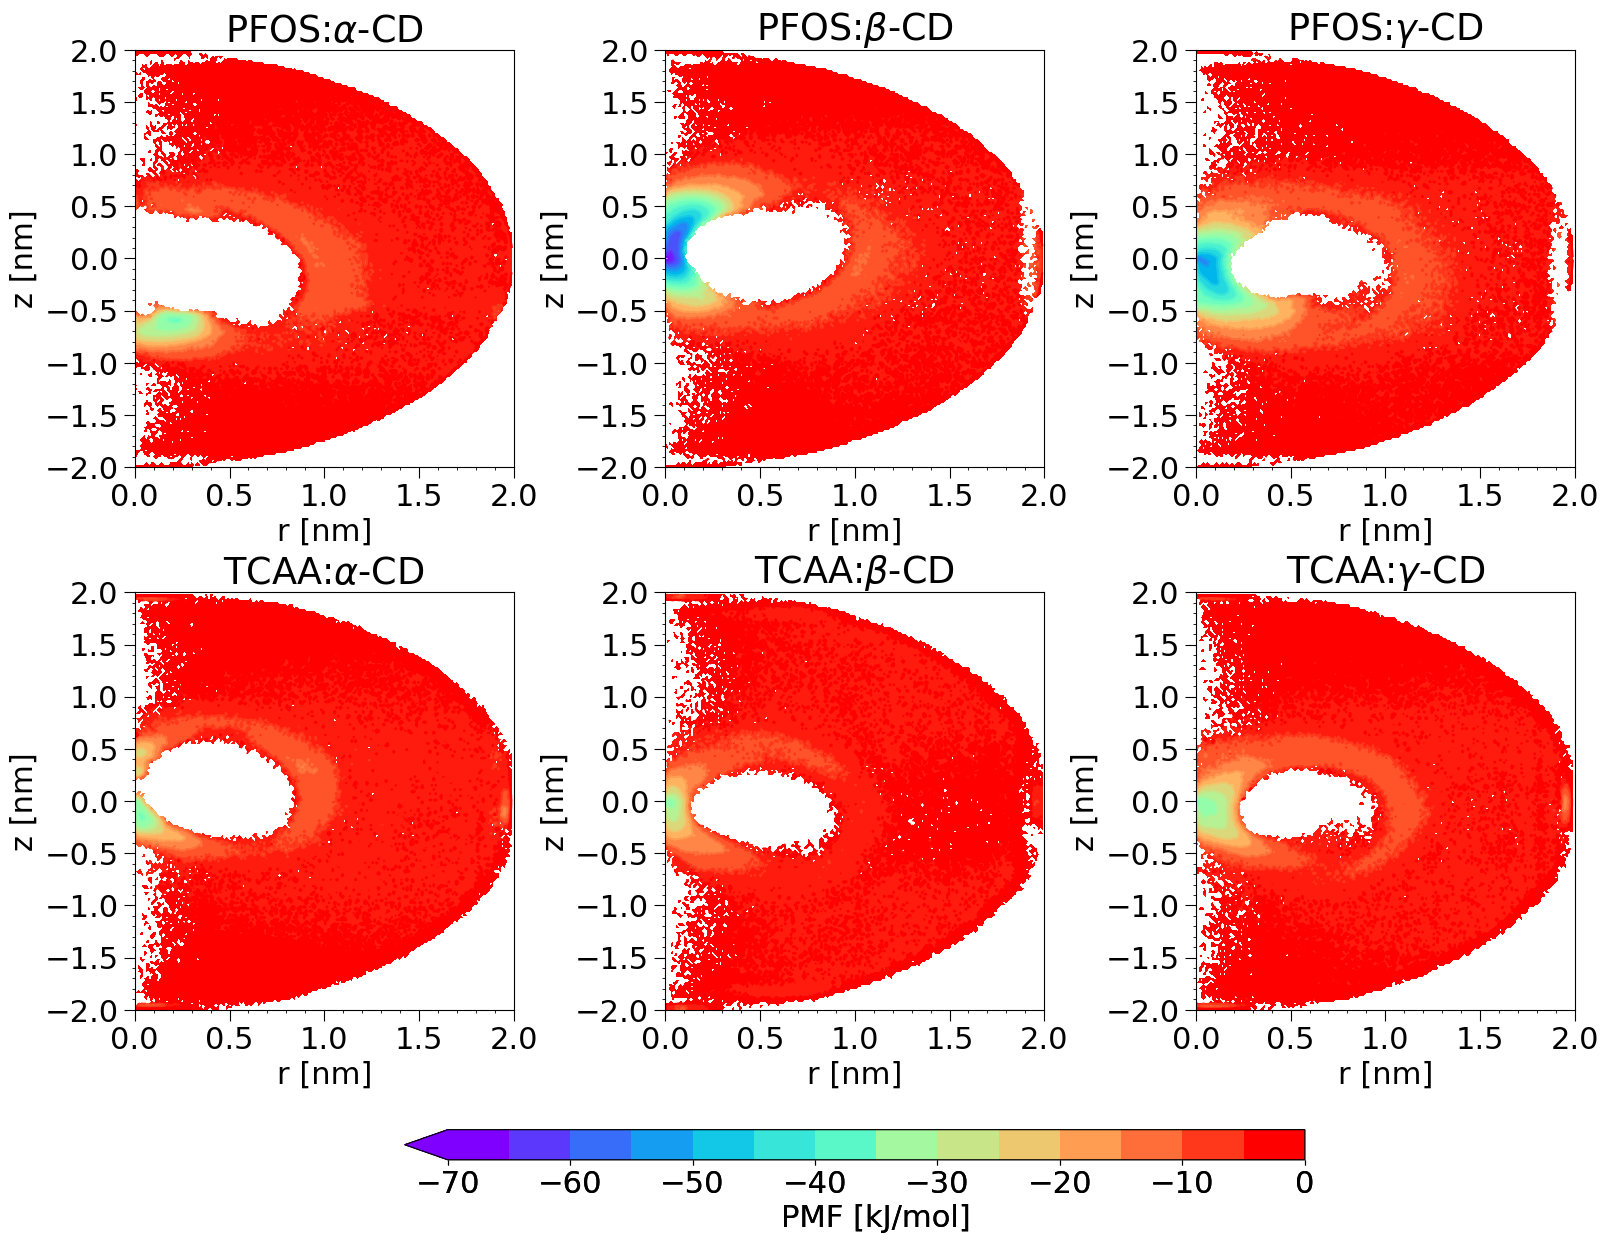

In [ ]:
# full spatial resolution plots for PFAS-CD systems
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

# Set the figure size
fig = plt.figure(figsize=(18, 12))

# Adjust spacing
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.3)

# Create a 3x3 grid
grid = GridSpec(2, 3)

probe= ['acd','bcd','gcd']
analyte = ['pfos','TCAA']
lbl = ['$\\alpha$-CD','$\\beta$-CD','$\\gamma$-CD']
selected_block = 0 # entire data is used.

for k, kk in enumerate(analyte):
    for i, ii in enumerate(probe):
        
        # Create subplots
        ax = plt.subplot(grid[k, i])
        
        #selected_fe = pmf_probe_analyte_zero_ref_global_minima
        selected_fe = pmf_probe_analyte_zero_ref_boundary
       
        fe = selected_fe[ii+'_'+kk]['block'+str(selected_block)]['fe']
        #fe = np.flip(fe,axis=0)
        xedges = selected_fe[ii+'_'+kk]['block'+str(selected_block)]['xedges']
        yedges = selected_fe[ii+'_'+kk]['block'+str(selected_block)]['yedges']
        
        x, y = np.meshgrid(xedges, yedges)
        #contour_levels = np.linspace(fe.min(), 0, 15) 
        contour_levels = np.linspace(-70, 0, 15) 
        
    
        ax.contour(x[:-1, :-1], y[:-1, :-1], fe, cmap='rainbow', levels=contour_levels,vmin=-70,vmax=0)
        contour_plot = ax.contourf(x[:-1, :-1], y[:-1, :-1], fe, cmap='rainbow', levels=contour_levels, extend='max',vmin=-70,vmax=0)
        
        #print(fe.max(), np.isinf(fe).any(), np.isnan(fe).any())
        
        from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
        from matplotlib.cm import get_cmap
        from matplotlib.colors import ListedColormap
        if i==2: #ldns
            cbar_ax = fig.add_axes([0.25, -0.025, 0.5, 0.025]) #x-location, y-location, width, height of bar
            tick_bounds = [-70,-60,-50,-40,-30,-20,-10,0]
            bounds = [-70,-65,-60,-55,-50,-45,-40,-35,-30,-25,-20,-15,-10,-5,0]
            ncolors = get_cmap('rainbow')(np.linspace(0, 1, len(bounds)))
            cmap = ListedColormap(ncolors)
            norm = mpl.colors.BoundaryNorm(bounds, len(bounds))
            cb = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                           boundaries=bounds, 
                                           norm=mpl.colors.Normalize(vmin=bounds[0], vmax=bounds[-1]),
                                           extend='min',
                                           spacing='uniform', orientation='horizontal')
            #cb.ax.set_xticklabels(bounds)
            cb.ax.set_xticks(tick_bounds)
            cb.set_label('PMF [kJ/mol]')
            

        fe_beyond_cutoff = []
        print(xedges.min(), xedges.max(), yedges.min(), yedges.max())
        for ki in range(xedges.shape[0]-1):
            for kj in range(yedges.shape[0]-1):
                
                
                if np.isnan(fe[kj,ki]) or np.isinf(fe[kj,ki]):
                    continue

                if .99 <= xedges[ki] <= 1.01 and -0.94  <= yedges[kj] <= 0.95:
                    fe_beyond_cutoff.append(fe[kj,ki])

        ax.set_xlabel('r [nm]')
        ax.set_ylabel('z [nm]')
        ax.set_title(kk.upper()+':'+lbl[i])
       
        ax.xaxis.set_major_locator(MultipleLocator(0.5))
        ax.set_xlim(0.0,2.0001)
        ax.set_ylim(-2,2.0001)
        ax.yaxis.set_major_locator(MultipleLocator(0.5))
        ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
        ax.yaxis.set_minor_locator(AutoMinorLocator(n=5))
        ax.tick_params(which='major', length=8)
        ax.tick_params(which='minor', length=2)
        plt.savefig('M1.png',dpi=300)
        

        

#### Compute deltaG and kb with 2D simpson, 50-500 blocks, cutoff 0.6-1.4 nm

In [ ]:
V0 = 1661*1e-3
Vf = 32*np.pi/3
CP = V0/Vf
kb = 8.31446261815324*0.001 #kJ/molK
temperature = 300
kbt = kb*temperature  #kJ/mol
probe= ['acd','bcd','gcd']
analyte = ['TCAA','pfos']
#choose number of blocks
blocks = 1
#define dimensions in r and z directions
#dimz = 100
#dimr = 100

pmf_probe_analyte_zero_ref_boundary = {} # collect pmfs
pmf_probe_analyte_zero_ref_global_minima = {} # collect pmfs
dimvec = [50,100,250,500]
cutvec = [0.6,0.8,1,1.2,1.4]

deltag_kb_probe_analyte_block = {}
cutoff1 = np.sqrt(3.5)
overmat = []
iii = 0
for ii in probe:
    for kk in analyte:
        submatkb = np.zeros([len(dimvec),len(cutvec)])
        submatdG = np.zeros([len(dimvec),len(cutvec)])
        submatcut = np.zeros([len(dimvec),len(cutvec)])
        submatstd = np.zeros([len(dimvec),len(cutvec)])
        
        for ll in range(len(dimvec)):
            for mm in range(len(cutvec)):
                dimz = dimvec[ll]
                cutoff = cutvec[mm]
                dimr = dimz
                pmf_probe_analyte_zero_ref_global_minima[ii+'_'+kk] = {}
                pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]  = {}

                deltag_kb_probe_analyte_block[ii+'_'+kk] = {}

                #create holders
                fep = []
                avgFE,sdFE = [],[]
                avgkb,sdkb = [],[]
                #load data 
                colvarFile = '/project2/andrewferguson/maxtopel/PFAS_TACC/system-cd/reweights/'+kk+'-'+ii+"/COLVAR_reweight" #simDir + systemDir + colvarFileName

                colvarData = pd.read_csv(colvarFile, comment="#", 
                                         delim_whitespace=True,names=["time", "angle", "r", 
                                                                      "baxis","mag", "pr", "pz", "bias"],
                                         skip_blank_lines=True)

                # discard initial few frames [frames where free energy is still being mapped]
                # subsample and randomize
                if kk=='pfos': 
                    s = 50000
                    d = 500001
                    colvarD = colvarData[s:d].sample(frac = 1)
                else:
                    s = 100000
                    d = 1000000
                    colvarD = colvarData[s:d:2].sample(frac = 1)        
                jmp = len(colvarD)//blocks


                for jj in range(blocks): 
                    colvarData_init = colvarD[jmp*jj:jmp*(jj+1)] 
                    print(jmp*jj,jmp*(jj+1))


                    colvarData_2 = colvarData_init[(colvarData_init['r'] < cutoff1)]
                    colvarData_3 = colvarData_2[(colvarData_2['baxis'] < cutoff1)]
                    colvarData = colvarData_3[(colvarData_3['baxis'] >= -cutoff1)]
                    ############################################################################################################
                    #make a 2D heat map
                    bias = colvarData['bias'] 
                    r = colvarData['r']
                    z = colvarData['baxis']
                    
                    # calculate weights of each frame in colvarData - CHECK THIS APPROACH (SUMMING THE BIASES)
                    weights = np.exp((bias) /kbt)        
                    xedges = np.linspace(0,cutoff1,dimr)
                    yedges = np.linspace(-cutoff1,cutoff1,dimz)
                    #print(xedges,yedges)
                    dr,dz = abs(xedges[0]-xedges[1]),abs(yedges[0]-yedges[1])
                    # get unbiased probabilities
                    fe, xedges,yedges = np.histogram2d(r,z,range=[[0,cutoff1],[-cutoff1,cutoff1]],
                                                       bins=(xedges,yedges),
                                                       weights=weights,density=True)

                    fe = fe.T
                    feDf = -kbt*np.log(fe) # Compute free energy

                    ######## correction
                    #correction
                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):
        #                     if xedges[ki]**2 + np.abs(yedges[kj])**2 > 1.25: # 2.0:
                   
                            if np.isnan(feDf[kj,ki]) or np.isinf(feDf[kj,ki]):
                                continue
    
                            s = np.sqrt(xedges[ki]**2+yedges[kj]**2)
                            feDf[ki,kj] += preFactor*np.log(s)
####################################

            
                    # Find values of free energy on the boundary of the surface
                    avg_fe_beyond_cutoff=[]
                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):

                            if np.isnan(feDf[kj,ki]) or np.isinf(feDf[kj,ki]):
                                continue
                           # print(bool(xedges[ki]>0.8),ki, xedges[ki])
                            #if 1.48 <= xedges[ki] < 1.5 and -1.48**2 <= yedges[kj]**2 < 1.5**2:
                            if xedges[ki] > cutoff or yedges[kj] < -cutoff or yedges[kj] > cutoff:
                                avg_fe_beyond_cutoff.append(feDf[kj,ki])
                        



                    avg_fe_beyond_cutoff = np.array(avg_fe_beyond_cutoff)
                 #   print(avg_fe_beyond_cutoff,len(avg_fe_beyond_cutoff))
                    cutmean = avg_fe_beyond_cutoff.mean()
                    cutstd = avg_fe_beyond_cutoff.std()
                    feDf_zero_ref_boundary = feDf - avg_fe_beyond_cutoff.mean() #collect_fe_k_max # UNCOMMENT THIS FOR SETTING BOUNDARY FREE ENERGY TO ZERO
                    _block_data_boundary = {'fe': feDf_zero_ref_boundary,
                                            'xedges': xedges,
                                            'yedges': yedges}

                    pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]['block'+str(jj)] = _block_data_boundary

                    selected_fe = pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]['block'+str(jj)]['fe']


                    ##Compute deltaG and kb
                    ##Also visualize the cutoff area for bounded region
                    print('Computing free energies ...')
                    dgh=0
                    dgh_unbound = 0
                    #simulation_volume = 0 # term 1/C in Kb. 1/(simulation concentration)

                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):

                           
                            # integrate below the upper cutoff of the above region.
                            if xedges[ki] < cutoff and (yedges[kj] > -cutoff and yedges[kj] < cutoff):
                
                                # convert selected_fe to probability (redundant step; done previously for visualization)
                                #dgh += np.exp(-selected_fe/kbt)[kj,ki]*dr*dz*xedges[ki]
                                dgh += np.exp(-selected_fe[kj,ki]/kbt)*dr*dz*xedges[ki]

                    dg = -kbt*np.log(2*np.pi*dgh*(1/V0))
                    kb = (1/V0)*2*np.pi*dgh

                    print(f'{ii.upper()}:{kk.upper()} Block:{jj} Kb:{kb} dG:{dg} kJ/mol cutmean:{cutmean} cutstd:{cutstd}')
                    print(f'{ii.upper()}:{kk.upper()}', f' dimz: {dimz} cutoff: {cutoff}')
                    deltag_kb_probe_analyte_block[ii+'_'+kk]['block'+str(jj)] = {'deltag': dg, 'kb': kb}
                submatkb[ll,mm] = kb
                submatdG[ll,mm] = dg
                submatcut[ll,mm] = cutmean
                submatstd[ll,mm] = cutstd
            
        overmat.append([submatkb,submatdG,submatcut,submatstd])
    

0 450000
Computing free energies ...
ACD:TCAA Block:0 Kb:7.20328343137247 dG:-4.92516410817244 kJ/mol cutmean:13.507150257378198 cutstd:3.5105387790739933
ACD:TCAA  dimz: 50 cutoff: 0.6
0 450000
Computing free energies ...
ACD:TCAA Block:0 Kb:9.13358754230741 dG:-5.517374021616558 kJ/mol cutmean:13.513934749823827 cutstd:3.493687434119402
ACD:TCAA  dimz: 50 cutoff: 0.8
0 450000
Computing free energies ...
ACD:TCAA Block:0 Kb:23.709268848340415 dG:-7.896742508802689 kJ/mol cutmean:13.75563866946357 cutstd:3.377199246021308
ACD:TCAA  dimz: 50 cutoff: 1
0 450000
Computing free energies ...
ACD:TCAA Block:0 Kb:32.56539316024092 dG:-8.688405986014192 kJ/mol cutmean:13.875648756992003 cutstd:3.438305301302426
ACD:TCAA  dimz: 50 cutoff: 1.2
0 450000
Computing free energies ...
ACD:TCAA Block:0 Kb:46.91276111052489 dG:-9.598938332047396 kJ/mol cutmean:14.191985507602386 cutstd:3.5735907405031546
ACD:TCAA  dimz: 50 cutoff: 1.4
0 450000
Computing free energies ...
ACD:TCAA Block:0 Kb:9.032232782

In [ ]:
V0 = 1661*1e-3
Vf = 32*np.pi/3
CP = V0/Vf
kb = 8.31446261815324*0.001 #kJ/molK
temperature = 300
kbt = kb*temperature  #kJ/mol
probe= ['acd','bcd','gcd']
analyte = ['TCAA','pfos']
#choose number of blocks
blocks = 3
#define dimensions in r and z directions
#dimz = 100
#dimr = 100

pmf_probe_analyte_zero_ref_boundary = {} # collect pmfs
pmf_probe_analyte_zero_ref_global_minima = {} # collect pmfs
dimvec = [200]
cutvec = [0.8,1,1.2,1.4,1.6]

deltag_kb_probe_analyte_block = {}
cutoff1 = np.sqrt(3.5)
dgs = []
kbs = []
kbe = []
dge = []
iii = 0
for ii in probe:
    for kk in analyte:
        kbvec = []
        dgvec = []
        kberrs = []
        dgerrs = []
    
        for ll in range(len(dimvec)):
            for mm in range(len(cutvec)):
                dimz = dimvec[ll]
                cutoff = cutvec[mm]
                dimr = dimz
                pmf_probe_analyte_zero_ref_global_minima[ii+'_'+kk] = {}
                pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]  = {}

                deltag_kb_probe_analyte_block[ii+'_'+kk] = {}

                #create holders
                fep = []
                avgFE,sdFE = [],[]
                avgkb,sdkb = [],[]
                #load data 
                colvarFile = '/project2/andrewferguson/maxtopel/PFAS_TACC/system-cd/reweights/'+kk+'-'+ii+"/COLVAR_reweight" #simDir + systemDir + colvarFileName

                colvarData = pd.read_csv(colvarFile, comment="#", 
                                         delim_whitespace=True,names=["time", "angle", "r", 
                                                                      "baxis","mag", "pr", "pz", "bias"],
                                         skip_blank_lines=True)

                # discard initial few frames [frames where free energy is still being mapped]
                # subsample and randomize
                if kk=='pfos': 
                    s = 50000
                    d = 500001
                    colvarD = colvarData[s:d].sample(frac = 1)
                else:
                    s = 100000
                    d = 1000000
                    colvarD = colvarData[s:d:2].sample(frac = 1)        
                jmp = len(colvarD)//blocks

                lockb = []
                locdg = []
                for jj in range(blocks): 
                    colvarData_init = colvarD[jmp*jj:jmp*(jj+1)] 
                    print(jmp*jj,jmp*(jj+1))


                    colvarData_2 = colvarData_init[(colvarData_init['r'] < cutoff1)]
                    colvarData_3 = colvarData_2[(colvarData_2['baxis'] < cutoff1)]
                    colvarData = colvarData_3[(colvarData_3['baxis'] >= -cutoff1)]
                    ############################################################################################################
                    #make a 2D heat map
                    bias = colvarData['bias'] 
                    r = colvarData['r']
                    z = colvarData['baxis']
                    
                    # calculate weights of each frame in colvarData - CHECK THIS APPROACH (SUMMING THE BIASES)
                    weights = np.exp((bias) /kbt)        
                    xedges = np.linspace(0,cutoff1,dimr)
                    yedges = np.linspace(-cutoff1,cutoff1,dimz)
                    #print(xedges,yedges)
                    dr,dz = abs(xedges[0]-xedges[1]),abs(yedges[0]-yedges[1])
                    # get unbiased probabilities
                    fe, xedges,yedges = np.histogram2d(r,z,range=[[0,cutoff1],[-cutoff1,cutoff1]],
                                                       bins=(xedges,yedges),
                                                       weights=weights,density=True)

                    fe = fe.T
                    feDf = -kbt*np.log(fe) # Compute free energy

                    ######## correction
                    #correction
                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):
        #                     if xedges[ki]**2 + np.abs(yedges[kj])**2 > 1.25: # 2.0:
                   
                            if np.isnan(feDf[kj,ki]) or np.isinf(feDf[kj,ki]):
                                continue
    
                            s = np.sqrt(xedges[ki]**2+yedges[kj]**2)
                            feDf[ki,kj] += preFactor*np.log(s)
####################################

            
                    # Find values of free energy on the boundary of the surface
                    avg_fe_beyond_cutoff=[]
                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):

                            if np.isnan(feDf[kj,ki]) or np.isinf(feDf[kj,ki]):
                                continue
                           # print(bool(xedges[ki]>0.8),ki, xedges[ki])
                            #if 1.48 <= xedges[ki] < 1.5 and -1.48**2 <= yedges[kj]**2 < 1.5**2:
                            if xedges[ki] > cutoff or yedges[kj] < -cutoff or yedges[kj] > cutoff:
                                avg_fe_beyond_cutoff.append(feDf[kj,ki])
                        



                    avg_fe_beyond_cutoff = np.array(avg_fe_beyond_cutoff)
                 #   print(avg_fe_beyond_cutoff,len(avg_fe_beyond_cutoff))
                    cutmean = avg_fe_beyond_cutoff.mean()
                    cutstd = avg_fe_beyond_cutoff.std()
                    feDf_zero_ref_boundary = feDf - avg_fe_beyond_cutoff.mean() #collect_fe_k_max # UNCOMMENT THIS FOR SETTING BOUNDARY FREE ENERGY TO ZERO
                    _block_data_boundary = {'fe': feDf_zero_ref_boundary,
                                            'xedges': xedges,
                                            'yedges': yedges}

                    pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]['block'+str(jj)] = _block_data_boundary

                    selected_fe = pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]['block'+str(jj)]['fe']


                    ##Compute deltaG and kb
                    ##Also visualize the cutoff area for bounded region
                    print('Computing free energies ...')
                    dgh=0
                    dgh_unbound = 0
                    #simulation_volume = 0 # term 1/C in Kb. 1/(simulation concentration)

                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):

                           
                            # integrate below the upper cutoff of the above region.
                            if xedges[ki] < cutoff and (yedges[kj] > -cutoff and yedges[kj] < cutoff):
                
                                # convert selected_fe to probability (redundant step; done previously for visualization)
                                #dgh += np.exp(-selected_fe/kbt)[kj,ki]*dr*dz*xedges[ki]
                                dgh += np.exp(-selected_fe[kj,ki]/kbt)*dr*dz*xedges[ki]

                    dg = -kbt*np.log(2*np.pi*dgh*(1/V0))
                    kb = (1/V0)*2*np.pi*dgh

                    print(f'{ii.upper()}:{kk.upper()} Block:{jj} Kb:{kb} dG:{dg} kJ/mol cutmean:{cutmean} cutstd:{cutstd}')
                    print(f'{ii.upper()}:{kk.upper()}', f' dimz: {dimz} cutoff: {cutoff}')
                    deltag_kb_probe_analyte_block[ii+'_'+kk]['block'+str(jj)] = {'deltag': dg, 'kb': kb}
                    lockb.append(kb)
                    locdg.append(dg)

                kbvec.append(np.mean(lockb))
                kberrs.append(np.std(lockb))
                dgvec.append(np.mean(locdg))
                dgerrs.append(np.std(locdg))
            kbs.append(kbvec)
            kbe.append(kberrs)
            dgs.append(dgvec)
            dge.append(dgerrs)

    

0 150000
Computing free energies ...
ACD:TCAA Block:0 Kb:9.723994118144313 dG:-5.673614150397388 kJ/mol cutmean:12.77878517132987 cutstd:2.8452750405797578
ACD:TCAA  dimz: 200 cutoff: 0.8
150000 300000
Computing free energies ...
ACD:TCAA Block:1 Kb:10.121672236148454 dG:-5.773593333511506 kJ/mol cutmean:12.806444797509235 cutstd:2.85710781927752
ACD:TCAA  dimz: 200 cutoff: 0.8
300000 450000
Computing free energies ...
ACD:TCAA Block:2 Kb:9.878387785232214 dG:-5.712907138132945 kJ/mol cutmean:12.801334968163054 cutstd:2.862817993355545
ACD:TCAA  dimz: 200 cutoff: 0.8
0 150000
Computing free energies ...
ACD:TCAA Block:0 Kb:20.109637242702572 dG:-7.486007480031684 kJ/mol cutmean:13.042802445694774 cutstd:2.673666436943323
ACD:TCAA  dimz: 200 cutoff: 1
150000 300000
Computing free energies ...
ACD:TCAA Block:1 Kb:19.93037917013712 dG:-7.463673156001906 kJ/mol cutmean:13.067080535875306 cutstd:2.7797486222139884
ACD:TCAA  dimz: 200 cutoff: 1
300000 450000
Computing free energies ...
ACD:T

# Compute delta G and Kb

#### Plot free energies and kb

[-8.533597487807242, -3.9042909908375694, -8.593137146840178, -19.127936873956326, -36.67607651218133, -28.92081827311159]
[0.01256865984370343, 0.0128121208002618, 0.0225160517766876, 0.011359201080316437, 0.023328177171248857, 0.015348209770109275]
['acd_TCAA', 'bcd_TCAA', 'gcd_TCAA', 'acd_pfos', 'bcd_pfos', 'gcd_pfos']
[30.60608758943657, 4.783985999367644, 31.346321702027108, 2139.977112158412, 2430896.766287753, 108510.47971285872]
[0.15443979885354114, 0.024547438762571833, 0.2834634927241676, 9.736248022232664, 22786.671455571202, 669.0223672961288]
[6.99199826e+01 5.08132082e+05 3.46166548e+03]
[4.75056499e-01 5.43003952e+03 3.78872299e+01]
['acd_TCAA', 'bcd_TCAA', 'gcd_TCAA', 'acd_pfos', 'bcd_pfos', 'gcd_pfos']


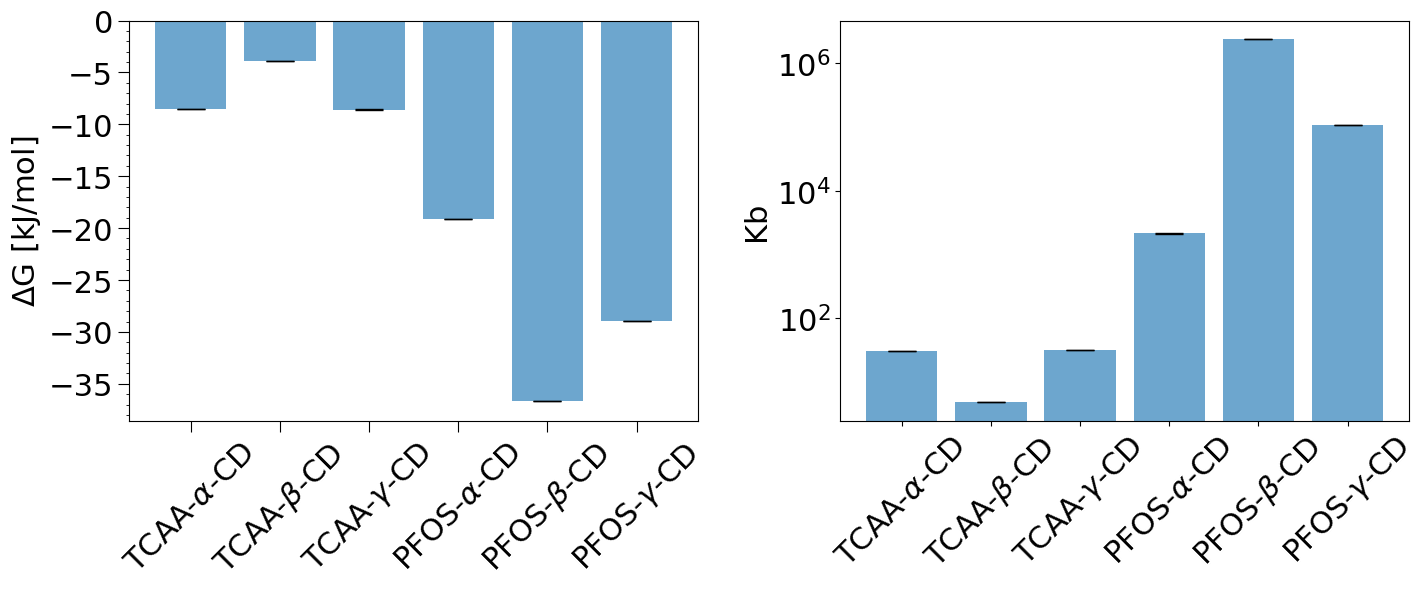

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from operator import add
# Set the figure size
fig = plt.figure(figsize=(16, 5))
lbl = ['TCAA-$\\alpha$-CD','TCAA-$\\beta$-CD','TCAA-$\\gamma$-CD','PFOS-$\\alpha$-CD','PFOS-$\\beta$-CD','PFOS-$\\gamma$-CD']

# Adjust spacing
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.25, hspace=0.25)

# Create a 3x3 grid
grid = GridSpec(1, 2)

probe= ['acd','bcd','gcd']
analyte = ['TCAA','pfos']

blocks = 3

deltag_kb_probe_analyte = {}
kji = 0
for k, kk in enumerate(analyte):
    for i, ii in enumerate(probe):
        
        selected_data = deltag_kb_probe_analyte_block
        
        deltag_blocks = []
        kb_blocks = []
        for bb in range(blocks):
            deltag = selected_data[ii+'_'+kk]['block'+str(bb)]['deltag']
            kb = selected_data[ii+'_'+kk]['block'+str(bb)]['kb']
            deltag_blocks.append(deltag)
            kb_blocks.append(kb)
            
            #print(deltag, kb)
            
        deltag_blocks = np.array(deltag_blocks)
        kb_blocks = np.array(kb_blocks)
        
        
        deltag_kb_probe_analyte[ii+'_'+kk] = {'avg_deltag': np.mean(deltag_blocks),
                                              'sd_deltag': np.std(deltag_blocks),
                                              'avg_kb': np.mean(kb_blocks),
                                              'sd_kb': np.std(kb_blocks)}

        
        
   

def convert_dict_of_dict(input_dict):
    result_dict = {}

    # Iterate through outer keys
    for outer_key, inner_dict in input_dict.items():
        # Iterate through inner keys
        for inner_key, value in inner_dict.items():
            # Check if the inner key is already in the result dictionary
            if inner_key not in result_dict:
                result_dict[inner_key] = {}

            # Add the value corresponding to the outer key
            result_dict[inner_key][outer_key] = value

    return result_dict

deltag_kb_probe_analyte = convert_dict_of_dict(deltag_kb_probe_analyte)



# # Create subplots
ax = plt.subplot(grid[0, 0])
# Extract keys and values from the dictionary
categories = list(deltag_kb_probe_analyte['avg_deltag'].keys())
values = list(deltag_kb_probe_analyte['avg_deltag'].values())
errors = list(deltag_kb_probe_analyte['sd_deltag'].values())
print(values)
print(errors)


# Plotting a bar chart
ax.bar(categories, values, yerr=errors, align='center', alpha=0.65, ecolor='black', capsize=10)
print(categories)
ax.set_xticks(categories, ['TCAA-$\\alpha$-CD','TCAA-$\\beta$-CD','TCAA-$\\gamma$-CD','PFOS-$\\alpha$-CD','PFOS-$\\beta$-CD','PFOS-$\\gamma$-CD'], rotation=45)
    
ax.set_ylabel(r'$\Delta$G [kJ/mol]')

#ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(5))
#ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=2)


# # Create subplots
ax = plt.subplot(grid[0, 1])
# Extract keys and values from the dictionary
categories = list(deltag_kb_probe_analyte['avg_kb'].keys())
values = list(deltag_kb_probe_analyte['avg_kb'].values())
errors = list(deltag_kb_probe_analyte['sd_kb'].values())
print(values)
print(errors)
values1 = values[0:3]
values2 = values[3::]
errors1 = errors[0:3]
errors2 = errors[3::]

print(np.divide(values2,values1))

print(np.multiply(np.sqrt(list(map(add,np.square(np.divide(errors1,values1)),np.square(np.divide(errors2,values2))))),np.divide(values2,values1)))
# Plotting a bar chart
ax.bar(categories, values, yerr=errors, align='center', alpha=0.65, ecolor='black', capsize=10)
print(categories)
ax.set_xticks(categories, ['TCAA-$\\alpha$-CD','TCAA-$\\beta$-CD','TCAA-$\\gamma$-CD','PFOS-$\\alpha$-CD','PFOS-$\\beta$-CD','PFOS-$\\gamma$-CD'], rotation=45)
    
ax.set_ylabel(r'Kb')
ax.set_yscale('log')


        



In [ ]:
############## PRODUCTION RUN

C0 = 1/(1661*1e-3)
kb = 8.31446261815324*0.001 #kJ/molK
temperature = 300
kbt = kb*temperature  #kJ/mol
probe= ['acd']
analyte = ['pfos']
#choose number of blocks
preFactor = 2*kbt #kJ/mol for entropy correction
blocks = 3 #3
cutoff1 = np.sqrt(3.5)
cutoff2 = 2
sfes_mast = []
smast = []
DG = []
ERR = []
dvec = np.linspace(0,1,101)[1:]
for dp in dvec:
    for cutoff in [1]:
        dimz = dimr
        pmf_probe_analyte_zero_ref_boundary = {} # collect pmfs
        pmf_probe_analyte_zero_ref_global_minima = {} # collect pmfs

        #for ii in probe:
        for kk in analyte:
            for ii in probe:
                dgs = []
                pmf_probe_analyte_zero_ref_global_minima[ii+'_'+kk] = {}
                pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]  = {}

                #create holders
                fep = []
                avgFE,sdFE = [],[]
                avgkb,sdkb = [],[]
                #load data 
                colvarFile = '/project2/andrewferguson/maxtopel/PFAS_TACC/system-cd/reweights/'+kk+'-'+ii+"/COLVAR_reweight" #simDir + systemDir + colvarFileName
                #print(colvarFile)
                colvarData = pd.read_csv(colvarFile, comment="#", 
                                         delim_whitespace=True,names=["time", "angle", "r", 
                                                                      "baxis","mag", "pr", "pz", "bias"],
                                         skip_blank_lines=True)
                print(len(colvarData))
                # discard initial few frames [frames where free energy is still being mapped]
                # subsample and randomize
                #if kk=='pfos': #probe=='acd' or probe=='gcd' and analyte=='pfos':

                s = 0 #50000
                d = int(len(colvarData)*dp) #d = -1 #500001
                colvarD = colvarData[s:d].sample(frac = 1)

                print(len(colvarD))
   
                jmp = len(colvarD)//blocks

                print(ii,kk, len(colvarD), blocks, jmp)

                #\print(colvarD)
                for jj in range(blocks): 
                    colvarData_init = colvarD[jmp*jj:jmp*(jj+1)] 
                    print(jmp*jj,jmp*(jj+1))


                    colvarData_2 = colvarData_init[(colvarData_init['r'] < cutoff1)]
                    colvarData_3 = colvarData_2[(colvarData_2['baxis'] < cutoff1)]
                    colvarData = colvarData_3[(colvarData_3['baxis'] >= -cutoff1)]
                    ############################################################################################################
                    #make a 2D heat map
                    bias = colvarData['bias'] 
                    r = colvarData['r']
                    z = colvarData['baxis']
                    
                    # calculate weights of each frame in colvarData - CHECK THIS APPROACH (SUMMING THE BIASES)
                    weights = np.exp((bias) /kbt)        
                    xedges = np.linspace(0,cutoff1,dimr)
                    yedges = np.linspace(-cutoff1,cutoff1,dimz)
                    #print(xedges,yedges)
                    dr,dz = abs(xedges[0]-xedges[1]),abs(yedges[0]-yedges[1])
                    # get unbiased probabilities
                    fe, xedges,yedges = np.histogram2d(r,z,range=[[0,cutoff1],[-cutoff1,cutoff1]],
                                                       bins=(xedges,yedges),
                                                       weights=weights,density=True)

                    fe = fe.T
                    feDf = -kbt*np.log(fe) # Compute free energy

            
                    # Find values of free energy on the boundary of the surface
                    avg_fe_beyond_cutoff=[]
                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):

                            if np.isnan(feDf[kj,ki]) or np.isinf(feDf[kj,ki]):
                                continue
                            s = np.sqrt(xedges[ki]**2+yedges[kj]**2)
                            if s > 1.2: #xedges[ki] > cutoff or yedges[kj] < -cutoff or yedges[kj] > cutoff:
                                avg_fe_beyond_cutoff.append(feDf[kj,ki])
                        



                    avg_fe_beyond_cutoff = np.array(avg_fe_beyond_cutoff)
                 #   print(avg_fe_beyond_cutoff,len(avg_fe_beyond_cutoff))
                    cutmean = avg_fe_beyond_cutoff.mean()
                    cutstd = avg_fe_beyond_cutoff.std()
                    feDf_zero_ref_boundary = feDf - avg_fe_beyond_cutoff.mean() #collect_fe_k_max # UNCOMMENT THIS FOR SETTING BOUNDARY FREE ENERGY TO ZERO
                    _block_data_boundary = {'fe': feDf_zero_ref_boundary,
                                            'xedges': xedges,
                                            'yedges': yedges}

                    pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]['block'+str(jj)] = _block_data_boundary

                    selected_fe = pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]['block'+str(jj)]['fe']
                    
                    
                    if ii == 'acd' and kk == 'TCAA' and jj == 0:
                        
                        
                        fig = plt.figure(figsize=(6, 5))
                        plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.6, hspace=0.35)
                        grid = GridSpec(1, 1)
                        ax = plt.subplot(grid[0, 0])
                        
                        fe = feDf_zero_ref_boundary

                    ##Compute deltaG and kb
                    ##Also visualize the cutoff area for bounded region
                    print('Computing free energies ...')
                    dgh=0
                    dgh_unbound = 0
                    #simulation_volume = 0 # term 1/C in Kb. 1/(simulation concentration)

                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):

                            s = np.sqrt(xedges[ki]**2+yedges[kj]**2)
                            # integrate below the upper cutoff of the above region.
                            if s<1.2:#xedges[ki] < cutoff and (yedges[kj] > -cutoff and yedges[kj] < cutoff):
                
                                # convert selected_fe to probability (redundant step; done previously for visualization)
                                dgh += np.exp(-selected_fe[kj,ki]/kbt)*dr*dz*xedges[ki]

                    
                    
                    dg = -kbt*np.log(2*np.pi*dgh*(1/V0))
                    kb = (1/V0)*2*np.pi*dgh
                    print(dg)
                    dgs.append(dg)
                  #  kbs.append(kb)
    DG.append(np.mean(dgs))
    ERR.append(np.std(dgs))
                    #sfes_mast.append(sfes)
                    #smast.append(sval)
                    #print(ii, kk, jj)
                    #print(dimr,dimz,cutoff)


500001
5000
acd pfos 5000 3 1666
0 1666
Computing free energies ...
0.32112578813686976
1666 3332
Computing free energies ...
0.2936357349804997
3332 4998
Computing free energies ...
-0.3588618841528228
500001
10000
acd pfos 10000 3 3333
0 3333
Computing free energies ...
-8.747142015185279
3333 6666
Computing free energies ...
-8.759062615735392
6666 9999
Computing free energies ...
-9.053334964222818
500001
15000
acd pfos 15000 3 5000
0 5000
Computing free energies ...
-9.092648998780811
5000 10000
Computing free energies ...
-8.934346717993215
10000 15000
Computing free energies ...
-9.264618100191045
500001
20000
acd pfos 20000 3 6666
0 6666
Computing free energies ...
-12.239337161654555
6666 13332
Computing free energies ...
-12.45083753211334
13332 19998
Computing free energies ...
-12.45726245813973
500001
25000
acd pfos 25000 3 8333
0 8333
Computing free energies ...
-13.3534074337982
8333 16666
Computing free energies ...
-13.236116232318075
16666 24999
Computing free energie